In [102]:
domain=list(df1['domain'])
labels=list(df1['label'])
for i in domain:
    if i.startswith('\'') and i.endswith('\''):
        indx=domain.index(i)
        i=i.replace('\'','')
        domain[indx]=i 

In [103]:
max_len = 75

In [104]:
url_int_tokens = [[printable.index(x) + 1 for x in d if x in printable] for d in domain]
#url_int_tokens[0:4]

In [105]:
from sklearn.cross_validation import train_test_split

In [106]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.preprocessing.text import Tokenizer
from keras import regularizers

In [107]:
def phising():
    #sentence_indices = Input(input_shape, dtype='int32')
    #X = sequence.pad_sequences(url_int_tokens, maxlen=max_len)
    main_input = Input(shape=(max_len,), dtype='int32', name='main_input')
    emb = Embedding(input_dim=100, output_dim=32, input_length=max_len,
                        dropout=0.2, W_regularizer=regularizers.l2(1e-4))(main_input)
    X = LSTM(32)(emb)
    # Add dropout with a probability of 0.5
    X =  Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = Dense(1, activation='sigmoid', name='output')(X)
    model = Model(inputs=[main_input], outputs=X)
    return model

In [108]:
model=phising()

/Users/saurabhprasad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  
/Users/saurabhprasad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=100, output_dim=32, input_length=75, embeddings_regularizer=<keras.reg...)`
  


In [109]:
model.compile(optimizer='adam', loss=' ', metrics=['accuracy'])

In [110]:
X = sequence.pad_sequences(url_int_tokens, maxlen=max_len)
X_train, X_test, y_train, y_test=train_test_split(X,labels,test_size=0.2,random_state=42)
find = model.fit(X_train, y_train, epochs=10, batch_size=1000, verbose=1)

Epoch 1/10
76726/76726 [==============================] - 27s 348us/step - loss: 0.5590 - acc: 0.7242
Epoch 2/10
76726/76726 [==============================] - 26s 334us/step - loss: 0.3888 - acc: 0.8301
Epoch 3/10
76726/76726 [==============================] - 26s 333us/step - loss: 0.3416 - acc: 0.8542
Epoch 4/10
76726/76726 [==============================] - 22s 282us/step - loss: 0.3111 - acc: 0.8697
Epoch 5/10
76726/76726 [==============================] - 21s 280us/step - loss: 0.2896 - acc: 0.8807
Epoch 6/10
76726/76726 [==============================] - 22s 284us/step - loss: 0.2743 - acc: 0.8890
Epoch 7/10
76726/76726 [==============================] - 21s 279us/step - loss: 0.2596 - acc: 0.8965
Epoch 8/10
76726/76726 [==============================] - 22s 293us/step - loss: 0.2496 - acc: 0.9013
Epoch 9/10
76726/76726 [==============================] - 22s 286us/step - loss: 0.2413 - acc: 0.9040
Epoch 10/10
76726/76726 [==============================] - 22s 286us/step - loss: 

In [111]:
model.evaluate(X_test, y_test, verbose=1)

19182/19182 [==============================] - 10s 537us/step


[0.21983207755560621, 0.9120529663039502]

In [112]:
model.metrics_names

['loss', 'acc']

In [113]:
find.history.keys()

dict_keys(['loss', 'acc'])

In [114]:
pred = model.predict(X_test)

In [115]:
pred

array([[0.0526229 ],
       [0.7395837 ],
       [0.9966648 ],
       ...,
       [0.79515964],
       [0.9996625 ],
       [0.01850021]], dtype=float32)

In [116]:
def predict(x_input):
    #print(x_input)
    url_int_tokens_1=[[printable.index(x) + 1 for x in d if x in printable] for d in x_input]
    #print(url_int_tokens_1)
    X_1 = sequence.pad_sequences(url_int_tokens_1, maxlen=max_len)
    p = model.predict(X_1)
    #print(p)
    #print(model.predict(X_1))
    return "not_malicious" if p < 0.5 else "malicious"
x_input=["https://www.quora.com/How-do-I-fix-a-Unicode-error-while-reading-a-CSV-file-with-a-pandas-library-in-Python-3-6"]
print(predict(x_input))

not_malicious


In [117]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [118]:
roc_auc_score(y_test, pred)

0.9700365222951286

In [119]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [120]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [121]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [122]:
import matplotlib.pyplot as plt

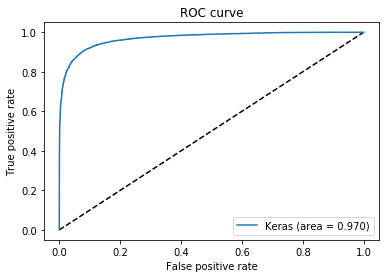

In [123]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

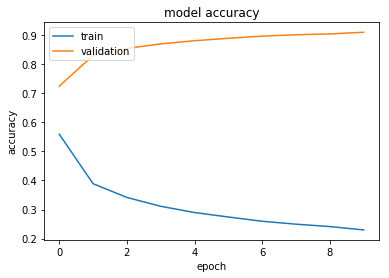

In [127]:
# summarize history for accuracy
plt.plot(find.history['loss'])
plt.plot(find.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

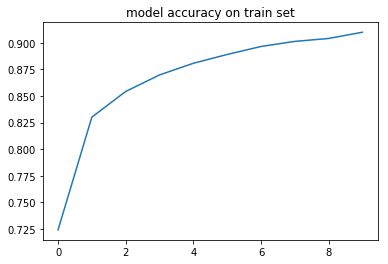

In [125]:
plt.plot(find.history['acc'])
plt.title('model accuracy on train set')
plt.show()